In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random
import pickle as pkl
import gzip

import games
import synthetic_data

In [2]:
class Evaluate:

    def __init__(self, ):
        pass

    def get_feedback(self, game, action, outcome ):
        return game.FeedbackMatrix[ action ][ outcome ]
        
    def deploy(self, game, horizon, alg, context_generator):

        history = [] 
        cumRegret =  []
        t = 0
        global_loss = []
        global_losses = []
        
        for t in range(horizon):
            
            context, distribution = context_generator.get_context()
            context = context.reshape( (1, -1) )
            outcome = np.argmax(distribution) 
            # distribution = np.array([1-outcome, outcome])
            print('distribution', distribution, 'outcome', outcome, )

            print('context shape',context.shape)
            action, data = alg.get_action(t, context)

            data['context'] = context 
            history.append( data )
            
            feedback =  self.get_feedback( game, action, outcome )

            loss, losses = alg.update(action, feedback, outcome, t, context )

            global_loss.append(loss)
            global_losses.append(losses)

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret.append( val )
            t+=1

            print('t', t, 'action', action, 'outcome', outcome, 'regret',val)
            print()
            
        return history, cumRegret, global_loss, global_losses

In [5]:
alg.ulist

AttributeError: 'Egreedy' object has no attribute 'ulist'

In [3]:
import cbpside
import rand_cbpside
import randneuralcbp
import cesa_bianchi
import random_algo
import random_algo2
import old_files.ineural as ineural
import ineural_multi
import margin_based

seed = 3
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

m = 100
H = 200
horizon = 9999

##### train and test data:

context_generator = synthetic_data.MNISTcontexts()

game = games.game_case2( )

nclasses = 10
alg = random_algo.Egreedy(game, nclasses, m, 'cuda:0')
alg.reset(context_generator.d)


# lbd_neural = 0
# lbd_reg = 1
# sigma = 1/8
# K = 100
# epsilon = 10e-7
# alg = randneuralcbp.CBPside( game, 1.01, lbd_neural, lbd_reg, sigma, K, epsilon, m, H,  'cuda:0')
# alg.reset(context_generator.d)

# budget = 9999
# nclasses = 10
# alg = ineural_multi.INeurALmulti(budget, nclasses, 'cuda:0')
# alg.reset(context_generator.d)

evaluator = Evaluate()

In [4]:
history, cumRegret, global_loss, global_losses = evaluator.deploy(game, horizon, alg, context_generator)

distribution [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] outcome 5
context shape (1, 784)
t 1 action 7 outcome 5 regret 1

distribution [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] outcome 9
context shape (1, 784)
t 2 action 9 outcome 9 regret 1

distribution [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] outcome 9
context shape (1, 784)
t 3 action 3 outcome 9 regret 1

distribution [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] outcome 0
context shape (1, 784)
t 4 action 7 outcome 0 regret 1

distribution [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] outcome 5
context shape (1, 784)
t 5 action 6 outcome 5 regret 0

distribution [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] outcome 9
context shape (1, 784)
t 6 action 0 outcome 9 regret 1

distribution [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] outcome 6
context shape (1, 784)
t 7 action 0 outcome 6 regret 1

distribution [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] outcome 3
context shape (1, 784)
t 8 action 6 outcome 3 regret 1

distribution [0, 0, 0, 0, 0, 0, 0, 0, 1, 0] outcome 8
context shape (1, 784)
t 9 action 6 outcome 8 regret 1

distributi

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import one_hot
dataloader = DataLoader(alg.hist, batch_size=1000, shuffle=True)
for X, feedbacks in dataloader:
    
    X = X.to(alg.device).float() 
    print(X.shape)
    feedbacks = one_hot(feedbacks, num_classes=10).to(alg.device).float()

    
    weights = torch.from_numpy( alg.weights ).squeeze(0).float().to(alg.device)
    print(weights.shape)
    print(alg.func(X).shape)
    pred = alg.func(X) @ weights.T

torch.Size([3, 784])
torch.Size([10, 21])
torch.Size([3, 21])


In [ ]:
import torch
from torchvision import datasets, transforms

# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])
# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
# test_loader = list(test_loader)
# index = 0
# x, y = test_loader[index]
# x = x.flatten()
x.shape[0]

784

In [ ]:
plt.plot( np.cumsum(cumRegret) )
plt.ylim( (0,10000) )

(0.0, 10000.0)

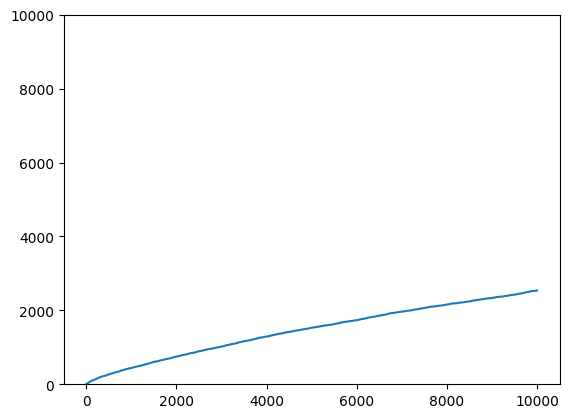

In [5]:
plt.plot( np.cumsum(cumRegret) )
plt.ylim( (0,10000) )

(0.0, 10000.0)

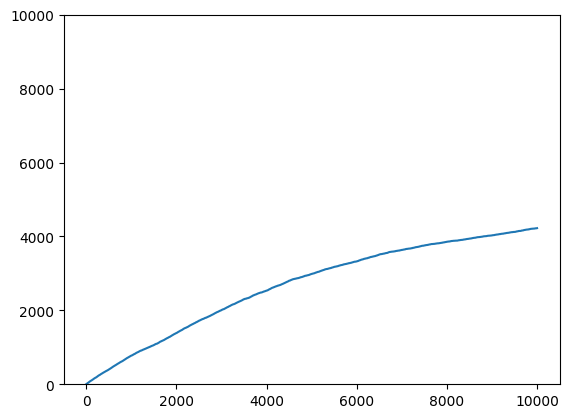

In [5]:
plt.plot( np.cumsum(cumRegret) )
plt.ylim( (0,10000) )

Text(0, 0.5, 'Loss')

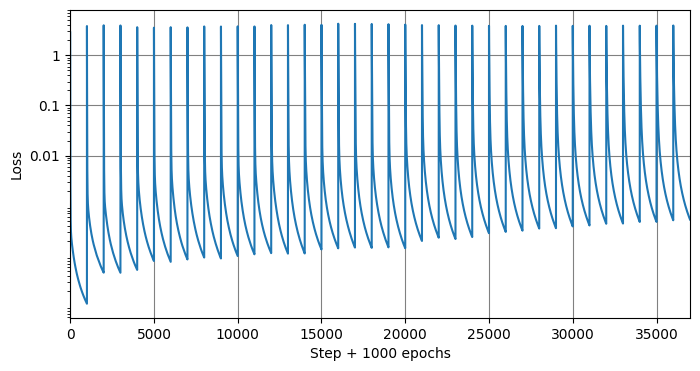

In [6]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.hstack( [ i for i in global_loss if len(i)>0 ] )

plt.figure(figsize=(8, 4))
# plt.ylim( (0, 10) )
plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, len(new_global_loss)) )


def generate_custom_ticks(start, horizon, end, increment, label_increment):
    custom_ticks = list(range(start, end+1 , increment))
    custom_tick_labels = [ str(i) for i in range(start, horizon , label_increment)]
    return custom_ticks, custom_tick_labels

# Define the parameters
start_value = 0
end_value = len(new_global_loss) 
tick_increment = 1000
label_increment = 50
horizon = 1000

# custom_ticks, custom_tick_labels = generate_custom_ticks(start_value, horizon, end_value, tick_increment, label_increment)

# plt.xticks(custom_ticks, custom_tick_labels, rotation=45, fontsize=7)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss )
plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')

# plt.savefig('./figures/loss_evolution.png', dpi=380, bbox_inches='tight')


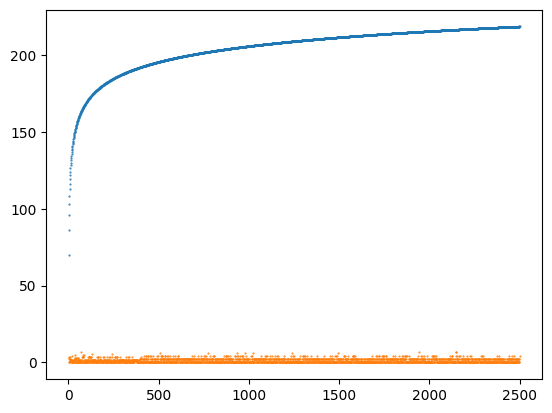

In [ ]:


def obtain_probability(t , factor):

    sigma = 1/2
    K = 100
    epsilon = 10e-7

    def divide_interval(start, end, k):
        intervals = np.linspace(start, end, k).tolist()
        return intervals

    # U = np.sqrt( self.alpha  * np.log(t) ) 

    U =  factor
    rhos = divide_interval(0, U, K)
    p_m_hat =  np.array([ np.exp( -(rhos[i]**2) / 2*(sigma**2)  )  for i in range(len(rhos)-1) ] )
    p_m = (1 - epsilon) * p_m_hat / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
        
    Z = np.random.choice(rhos, p= p_m)
    return Z

deterministic = []
rand = []

for t in range(1, 2500):
    sigma_i = 2
    d = 730
    N = 3
    H = 1
    lbd_reg = 1
    factor = sigma_i * (  np.sqrt( 2 * ( d  * np.log( 1 + t * np.log(N * H)/lbd_reg ) +  np.log(1/t**2) ) ) + np.sqrt(lbd_reg) * sigma_i )
    rand_value = obtain_probability(t , factor)
    deterministic.append(factor)
    rand.append(rand_value)


plt.plot(range(1,2500), deterministic, '.', markersize = 1)

plt.plot(range(1,2500), rand, '.', markersize = 1)



(array([1.362e+03, 7.500e+02, 1.380e+02, 1.900e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.290e+02]),
 array([0.        , 0.90886871, 1.81773743, 2.72660614, 3.63547486,
        4.54434357, 5.45321229, 6.362081  , 7.27094972, 8.17981843,
        9.08868714]),
 <BarContainer object of 10 artists>)

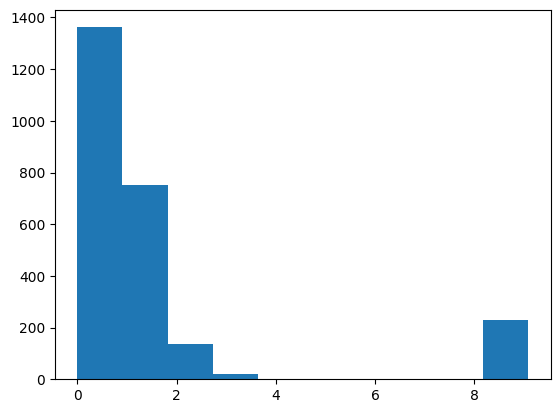

In [ ]:
plt.hist(rand, bins = 10)

In [ ]:
context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

V_it_inv = np.identity(20)

vals = []
rates = []

T = 10000

for t in range(1,T):

    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 

    latent_X = alg.func( torch.from_numpy( norm_context ).float().to(alg.device) ).cpu().detach().numpy()

    V_it_inv = V_it_inv - ( V_it_inv @ latent_X.T @ latent_X @ V_it_inv ) / ( 1 + latent_X @ V_it_inv @ latent_X.T ) 

    val =  latent_X @ V_it_inv @ latent_X.T  
    rate = t**(2/3)  * ( 1.01 * np.log(t) )**(1/3)

    vals.append(val[0][0])
    rates.append(1/rate)

plt.plot(range(1,T), vals, '.' , markersize = 0.01, color = 'blue', label = 'pseudo-count')
plt.plot(range(1,T), rates, '.', markersize = 0.01, color = 'red', label = 'exploration threshold')
plt.yscale('log')
plt.legend()

NameError: name 'synthetic_data' is not defined